# App 10 : Blood pressure estimation using photoplethysmogram

Yangyang Zhao (yazhao@utu.fi) <br>
Guanghang Chen (guchen@utu.fi) <br>

## Introduction

Blood pressure estimation is a crucial aspect of monitoring cardiovascular health. Traditional methods of measuring blood pressure involve using a cuff to compress an artery and measure changes in blood flow. However, recent research has explored the use of photoplethysmography (PPG) for non-invasive blood pressure estimation. PPG involves measuring changes in light absorption by tissues, typically using a sensor placed on the skin. By analyzing the waveform of the PPG signal, it is possible to estimate blood pressure. This technology has the potential to revolutionize the way blood pressure is measured, making it more convenient and less invasive for patients.

The objective of the project is to extract systolic and diastolic blood pressure (BP) values from photoplethysmogram (PPG) signals using machine learning techniques. The data for the project is obtained from the MIMIC II online waveform database, which includes PPG signals from fingertip and arterial BP detected by invasive sensors. 

The dataset consists of 29599 records of 10-second PPG segments at sampling rate 125Hz, with separate "Train" and "Test" folders containing the PPG and BP records. The project involves pre-processing techniques such as filtering, feature extraction, standardization of data. For the features extraction particully, random forest regressor and graident boosting regressor will be fine-tuned and train, to help us selecting most contributed features we want. 

By training of two fine-tuned supervised machine learning regressors ( Support Vector Regressor (SVR) and Multi-Layer Perceptron (MLP) ), we can estimate  to estimate the SBP and DBP values. 

The performance of the two regressors is evaluated using the mean absolute error and concordance index (c-index) on the test set. 

Here is the flowchart of our project.

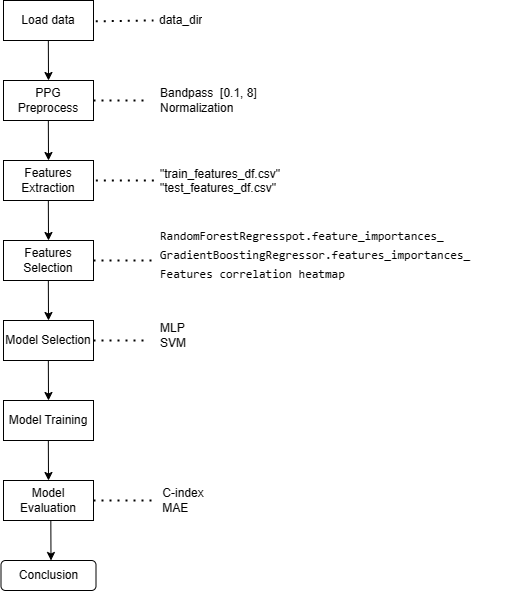

In [86]:
# import liberies
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import welch, periodogram 
import scipy.stats as stats
import neurokit2 as nk

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error
from lifelines.utils import concordance_index

import os 
import warnings
warnings.filterwarnings('ignore') # ignore warnings

%matplotlib inline

## (1) Load and plot data

In this part, we simply load ture blood presure label and PPG segementations under "./Data" folder.

A example PPG signal was plot, and visualize its first, second Derivative, frequency domain, power density domain.

In [2]:
# implement useful functions for dataset loading and visualization here

# def read_from_filesname(filesname):
#     """Read records from files name list
#     - INPUT: filesname (list of str)
#     - OUTPUT: records_list (list of np.array)
#     """
#     records_list = []
#     for filename in filesname:
#         records_list.append(np.loadtxt(filename, dtype=np.float64, skiprows=1, delimiter=","))
    
#     return np.array(records_list)


def visualize_record(record, Fs=125):
    """Visualize segment of signal (RAW, 1st-ord, 2nd-ord, freq, power density)
    - INPUT: record (np.array), Fs (int)
    - OUTPUT: None
    """
    x_t = np.linspace(0, (len(record)/Fs), len(record)) # time specturm
    first_derivative = np.gradient(record, x_t) # calculate 1st order derivative
    second_derivative = np.gradient(first_derivative, x_t) # calculate 2nd order derivative
    x_freq = rfftfreq(record.shape[0], 1/Fs) # calculate frequency specturm
    sign_freq = rfft(record) # cakculate record in frequency domain
    x_den, sign_den = welch(record, Fs, nperseg=10*Fs) # Estimate power spectral density using Welch’s method
    
    # visualize 
    fig = plt.figure(figsize=(9, 9))
    #plt.subplots_adjust(top=0.9)
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.plot(x_t, record, label='RAW')
    ax1.plot(x_t, first_derivative, label='1st-ord', alpha=0.6)
    ax1.plot(x_t, second_derivative, label='2nd-ord', alpha=0.6)
    ax1.set_ylim(-10, 10)
    ax1.legend()
    ax1.set(xlabel='Time[Sec]')
    ax1.grid('True')
    ax2 = fig.add_subplot(3, 1, 2)
    ax2.plot(x_freq, sign_freq)
    ax2.set_xlim(0, 8)
    ax2.set(xlabel='Freq[Hz]')
    ax2.grid('True')
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.semilogy(x_den, sign_den)
    ax3.set_xlim(0, 60)
    ax3.set(xlabel='Freq[Hz]', ylabel='Power Density[W/Hz]')
    ax3.grid('True')

In [3]:
# walk through './Data' folder
data_dir = './Data'
for dir, dirname, filesname, in os.walk(data_dir):
    print(f'Found {len(dirname)} directories and {len(filesname)} .csv files in {dir}')

Found 2 directories and 0 .csv files in ./Data
Found 2 directories and 0 .csv files in ./Data\Test
Found 0 directories and 1 .csv files in ./Data\Test\BP
Found 0 directories and 5924 .csv files in ./Data\Test\PPG
Found 2 directories and 0 .csv files in ./Data\Train
Found 0 directories and 1 .csv files in ./Data\Train\BP
Found 0 directories and 23675 .csv files in ./Data\Train\PPG


In [4]:
%time
# load true blood pressure labels
true_train_df = pd.read_csv('./Data/Train/BP/BP_train.csv', delimiter=',')
true_test_df = pd.read_csv('./Data/Test/BP/BP_test.csv', delimiter=',')

# prepare signal paths
train_filesname = [os.path.join("./Data/Train/PPG", filename) for filename in true_train_df['ppg_file']]
test_filesname = [os.path.join("./Data/Test/PPG", filename) for filename in true_test_df['ppg_file']]

# load training and testing PPG records as numpy array (not used)
#train_record_list = read_from_filesname(train_filesname)
#test_record_list = read_from_filesname(test_filesname)


CPU times: total: 0 ns
Wall time: 0 ns


,sbp,dbp,ppg_file
20330,132.240528,66.779659,PPG_20330.csv
15322,114.241475,50.822290,PPG_15322.csv
16704,142.575940,54.905658,PPG_16704.csv
21609,105.954481,61.232863,PPG_21609.csv
19119,147.434808,59.890628,PPG_19119.csv


,sbp,dbp,ppg_file
1284,131.703243,55.628550,PPG_24959.csv
1966,126.164321,68.313364,PPG_25641.csv
5075,164.121891,68.524304,PPG_28750.csv
2672,159.110491,66.408379,PPG_26347.csv
1885,100.024617,54.216797,PPG_25560.csv


Training label shape: (23675, 3)
Testing label shape: (5924, 3)
Training data null count : 
sbp         0
dbp         0
ppg_file    0
dtype: int64
Testing data null count : 
sbp         0
dbp         0
ppg_file    0
dtype: int64
Training data describe : 
                sbp           dbp
count  23675.000000  23675.000000
mean     136.575066     64.832465
std       23.115944     10.317785
min       77.404002     50.348453
25%      117.729806     57.589594
50%      137.183551     62.399259
75%      154.579716     69.860677
max      197.595700    143.767737
Testing data describe : 
               sbp          dbp
count  5924.000000  5924.000000
mean    136.206680    64.700264
std      22.875504    10.141629
min      77.146106    50.568301
25%     118.043691    57.483363
50%     136.075634    62.404174
75%     153.327711    69.738601
max     196.838085   149.931862


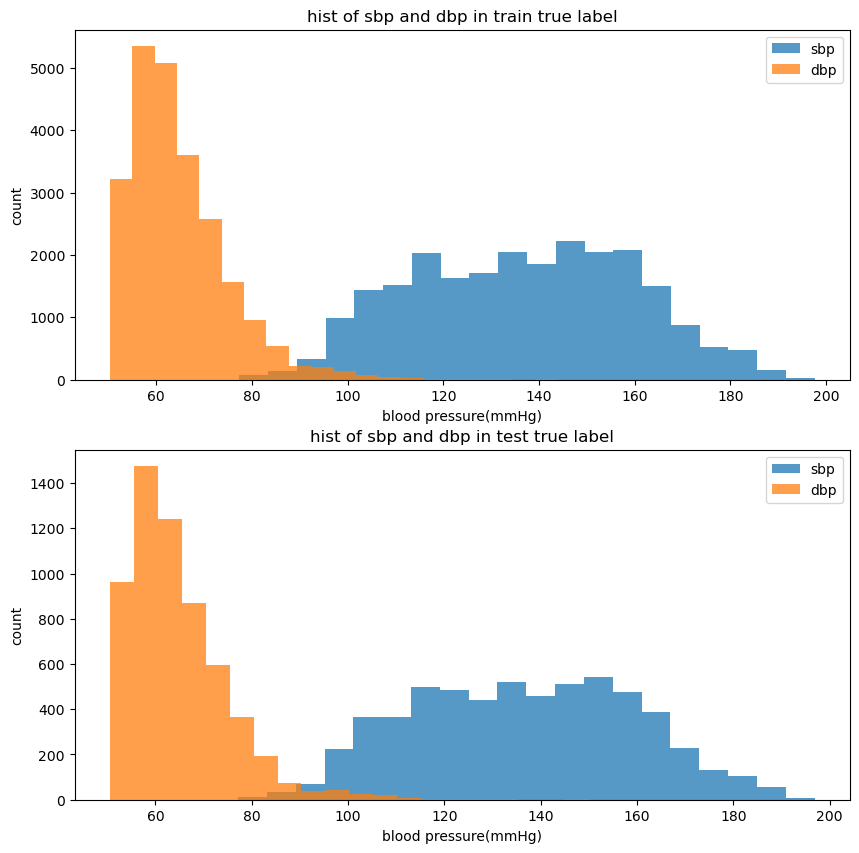

In [5]:
## simple explore train and test label

# display some samples
display(true_train_df.sample(5))
display(true_test_df.sample(5))


# check shape of data
print(f'Training label shape: {true_train_df.shape}')
print(f'Testing label shape: {true_test_df.shape}')
# check null value in labels 
print(f'Training data null count : \n{true_train_df.isnull().sum()}')
print(f'Testing data null count : \n{true_test_df.isnull().sum()}')
# describe the two label
print(f'Training data describe : \n{true_train_df.describe()}')
print(f'Testing data describe : \n{true_test_df.describe()}')


# plot the distribution of systolic and diastolic blood pressure
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
for i, true_df in enumerate([true_train_df, true_test_df]):
    axs[i].hist(true_df['sbp'], bins=20, alpha=0.75, label='sbp')
    axs[i].hist(true_df['dbp'], bins=20, alpha=0.75, label='dbp')
    axs[i].set_title(f'hist of sbp and dbp in {["train", "test"][i]} true label')
    axs[i].set_xlabel('blood pressure(mmHg)')
    axs[i].set_ylabel('count')
    axs[i].legend()


Length of 'train_filesname': 23675
Length of 'test filesname': 5924
vis_idx(train) = 10906 / 23675


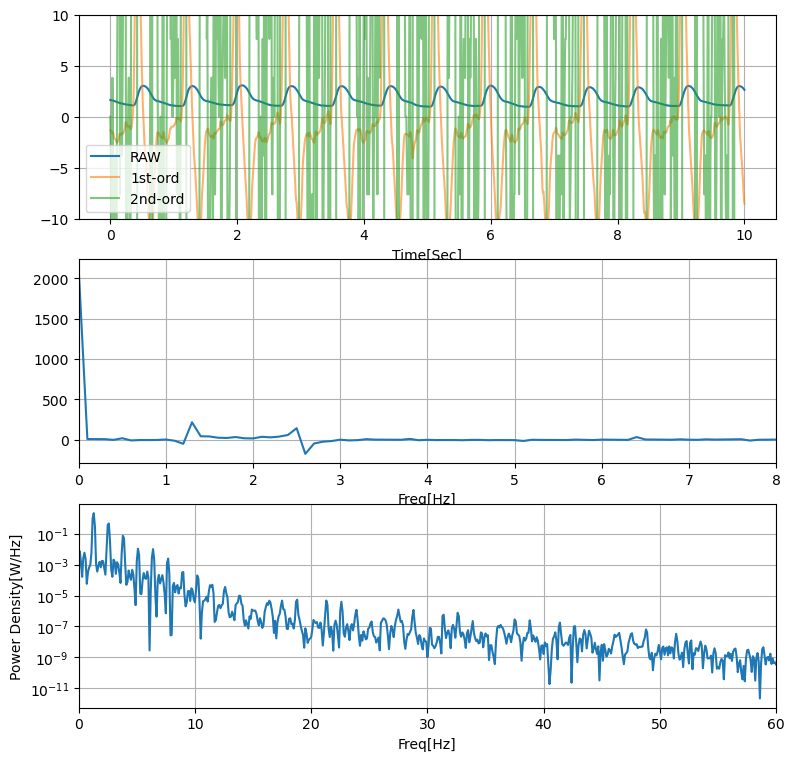

In [6]:
# simple explore train and test PPG records
print(f'Length of \'train_filesname\': {len(train_filesname)}')
print(f'Length of \'test filesname\': {len(test_filesname)}')

# randomly choose one training record to visualize
vis_idx = np.random.choice(len(train_filesname), 1)[0]
print(f"vis_idx(train) = {vis_idx} / {len(train_filesname)}")

# read the record and visualize
vis_record= pd.read_csv(train_filesname[vis_idx])
visualize_record(vis_record['ppg'].values, Fs=125)

## (2) Data preprocessing
 
 [Elgendi, M. (2012). On the analysis of fingertip photoplethysmogram signals. Current cardiology reviews, 8(1), 14-25.](https://www.ingentaconnect.com/content/ben/ccr/2012/00000008/00000001/art00003) is one of most cited PPG anlysis review on Google Scholar. It consider Powerline Interference, Motion Artifact, Low Amplitude PPG Signal into account, and give describution about them.

 'neurokit2' provide an implementation of elgendi's PPG preprocessing. the function 'ppg_clean' pre-processed as following:
    1. Check missing data point and give warning if so
    2. bandpass a 3 order butterworth filter between 0.5 Hz and 8Hz (motion artifact, powerline interference)
    3. Address baseline wander

   You can check more detail on [souce_code(ppg_clean)](https://neuropsychology.github.io/NeuroKit/_modules/neurokit2/ppg/ppg_clean.html#ppg_clean)


In [7]:
# impleent useful functions for data preprocessing here
def preprocessing(ppg_record, Fs=125):
    """robust preprocessing for PPG signal based on Elgendi, M. et al. (2012)
    1. remove baseline wander
    2. normalize the signal
    3. bandpass filter (0.1-8Hz)
    - INPUT
    'ppg_record' (np.array): raw PPG signal
    'Fs' (int): sampling rate
    - OUTPUT
    'clean_record' (np.array): preprocessed PPG signal
    'peaks' (np.array): detected peaks of PPG signal
    """
    processed_record, info = nk.ppg_process(ppg_record, sampling_rate=Fs)
    clean_record = processed_record['PPG_Clean']    
    peaks=info['PPG_Peaks']
    return clean_record, peaks 


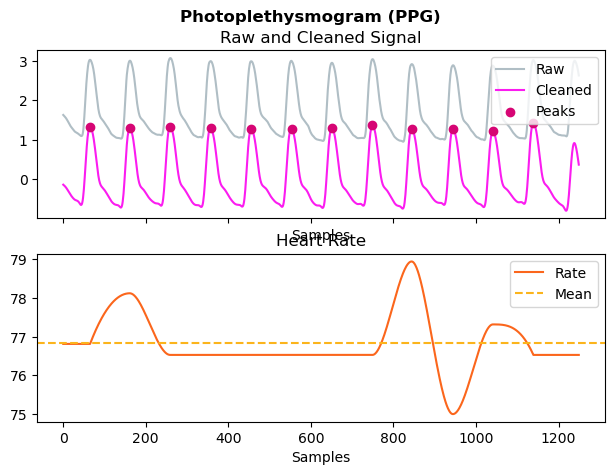

In [8]:
# visualize a example processed record
processed_record, peaks = nk.ppg_process(vis_record, sampling_rate=125)
nk.ppg_plot(processed_record)

## (3) Features extraction

Biomedical signals carry signatures of physiological events. So we are going to use different time-domain and frequency domain features to analyze. 

After processing the signals and detecting the peaks, we can obtain the inter-beat interval (IBI) between two successive heartbeats. Therefore, we can calculate the first feature, which is heart rate (HR) as HR=60/IBI. The following are some IBI-related features used in this project. 

- *MeanNN* ：The mean of the RR intervals. <br>
- *SDNN* ：The standard deviation of the RR intervals. <br>
- *RMSSD* ：The square root of the mean of the squared successive differences between <br>
- *adjacent RR intervals* . <br>
- *SDSD* ：The standard deviation of the successive differences between RR intervals. <br>
- *CVNN* ：The standard deviation of the RR intervals (**SDNN**) divided by the mean of the <br>
- *RR intervals* (**MeanNN**). <br>
- *MedianNN* ：The median of the RR intervals. <br>
- *MadNN* ：The median absolute deviation of the RR intervals. <br>
- *MCVNN* ：The median absolute deviation of the RR intervals (**MadNN**) divided by the <br>
- *median of the RR intervals* (**MedianNN**). <br>
- *IQRNN*：The interquartile range (**IQR**) of the RR intervals. <br>
- *Prc20NN* ：The 20th percentile of the RR intervals <br>
- *Prc80NN* ：The 80th percentile of the RR intervals <br>
- *MinNN* ：The minimum of the RR intervals <br>
- *MaxNN* ：The maximum of the RR intervals <br>
- *avg_rri* ：average of RR intervals<br>

These are also other time domain features, but they take the entire signal as input. <br>

- *Skewness* : Measures the asymmetry of a probability distribution.<br>
- *Kurtosis* : Measures the "peakedness" or flatness of a probability distribution.<br>
- *Cumulative residual entropy* : An alternative to Shannon differential entropy that uses the cumulative distribution function instead of the density function.<br>
- *SVD entropy* : Measures how many eigenvectors are needed to explain a dataset.<br>
- *Attention entropy* : Analyzes the frequency distribution of intervals between peaks in a time series.<br>
- *Increment entropy* : Quantifies the magnitudes of variations between adjacent elements based on a precision factor and standard deviation.<br>
- *Symbolic dynamic entropy* : Combines the merits of symbolic dynamics and information theory.<br>
- *Dispersion entropy* : Quantifies the degree of irregularity and complexity of fluctuations in a signal.<br>
- *Approximate entropy* : Quantifies the amount of regularity and unpredictability of fluctuations over time-series data.<br>
- *Sample entropy* : A modification of approximate entropy used for assessing the complexity of physiological time-series signals.<br>
- *Fuzzy entropy* : A combination of information theory and fuzzy set theory.<br>
- *Hierarchical entropy* : A generalization of multiscale entropy that contains redundant components and is sensitive to the dynamical richness of a time series.<br>

Frequency domain we obtain are :

- *Tolerance_r* : The optimized window size for calculating a complexity measure, returned as an integer.<br>
- *Powen* : Shannon Entropy Power (SEP) measures the effective variance of a random vector and is based on the estimation of the density of the variable.<br>
- *Klen* : Kozachenko-Leonenko (K-L) estimate of the differential entropy, also known as the nearest neighbor estimate of entropy.<br>
- *SpEn* : Spectral entropy (SE or SpEn) calculates the Shannon entropy of the normalized power spectral density of a signal in the frequency domain, treating it as a probability distribution.<br>





In [9]:
# implement useful functions for feature extraction here
def mad(x, constant=1.4826, **kwargs):
    """**Median Absolute Deviation: a "robust" version of standard deviation**
    Parameters
    ----------
    x : Union[list, np.array, pd.Series]
        A vector of values.
    constant : float
        Scale factor. Use 1.4826 for results similar to default R.
    Returns
    ----------
    float
        The MAD.
    Examples
    ----------
    .. ipython:: python
      import neurokit2 as nk
      nk.mad([2, 8, 7, 5, 4, 12, 5, 1])
    References
    -----------
    * https://en.wikipedia.org/wiki/Median_absolute_deviation
    """
    median = np.nanmedian(np.ma.array(x).compressed(), **kwargs)
    mad_value = np.nanmedian(np.abs(x - median), **kwargs)
    mad_value = mad_value * constant
    return mad_value


def IBI(peak):
    
    rri=np.diff(peak)
    
    return rri

def diff_IBI(IBI):
    diff_IBI=np.diff(IBI)
    return diff_IBI

def avg_IBI(IBI):
    avg_IBI =np.mean(IBI)/125
    return avg_IBI

def HeartRate(avg_IBI):
    HeartRate = 60.00/avg_IBI
    
    return HeartRate

def calculate_spectral_entropy(sig, fs=125):
    #compute PSD
    freq, PSD = periodogram(sig, fs)
    #spectral entropy
    pk = PSD/np.sum(PSD)
    spectral_entropy = stats.entropy(pk, base=2)
    return spectral_entropy

def calculate_power_band(sig, fs=125):
    band_list = [[0.1, 1], [0.5, 2.5], [2.5, 5.0], [5.0, 10.0], [10.0, 15.0], [15.0, 25.0]]
    power_band = []
    freq, PSD = periodogram(sig, fs)
    for freq_band in band_list:
        dr = freq_band[1] - freq_band[0]
        power_band.append(np.trapz(PSD[abs(freq - freq_band[0] - dr/2.0) <= dr/2.0]))
    return power_band
#frequency_band = [ulf, vlf, lf, hf, vhf]

def Tolerance_r(sig):
    parameters = nk.complexity_optimize(sig, show=False)
    Tolerance_r=parameters['Tolerance']
    
    return Tolerance_r


def IBI_feature(rri):
    """gathering 16 IBI features
    - INPUT
    'rri' (np.array): a vector of RR interval
    - OUTPUT
    'out' (dict): a dataframe contain 16 IBI features
    """
    
    out = {} 
    diff_rri=np.diff(rri)
    out["MeanNN"] = np.nanmean(rri)
    out["SDNN"] = np.nanstd(rri, ddof=1)
    out["RMSSD"] = np.sqrt(np.nanmean(diff_rri**2))
    out["SDSD"] = np.nanstd(diff_rri, ddof=1) 
    out["CVNN"] = out["SDNN"] / out["MeanNN"]
    out["CVSD"] = out["RMSSD"] / out["MeanNN"]
    out["MedianNN"] = np.nanmedian(rri)
    out["MadNN"] = mad(rri)
    out["MCVNN"] = out["MadNN"] / out["MedianNN"]  # Normalized
    out["IQRNN"] = stats.iqr(rri)
    out["Prc20NN"] = np.nanpercentile(rri, q=20)
    out["Prc80NN"] = np.nanpercentile(rri, q=80)
    out["MinNN"] = np.nanmin(rri)
    out["MaxNN"] = np.nanmax(rri)    
    out["avg_rri"] = avg_IBI(rri)
    out["heart_rate"] = HeartRate(out["avg_rri"])
    
    out= pd.DataFrame([out])   
    
    return out    

# entropy based feature
def entropy_feature(sig):
    """gathering 16 entropy features
    - INPUT
    'sig' (np.array): raw input PPG signal
    - OUTPUT
    'out2' (dataframe): a dataframe contain 16 entropy features
    """
    out2 = {} 
    out2["skewness"] = stats.skew(sig)
    out2["kurtosis"] =  stats.kurtosis(sig)
    out2["Tolerance_r"] =  Tolerance_r(sig)
    out2["powen"] = nk.entropy_power(sig)[0]
    out2["cumulativeresidual"] = nk.entropy_cumulativeresidual(sig,show=False)[0] 
    out2["svden"] = nk.entropy_svd(sig,delay=5, dimension=3,show=False)[0]
    out2["klen"] = nk.entropy_kl(sig,delay=1, dimension=3)[0]
    out2["SpEn"] = nk.entropy_spectral(sig)[0] 
    out2["atten"] = nk.entropy_attention(sig)[0]  
    out2["incren"] = nk.entropy_increment(sig)[0] 
    out2["sydyen"] = nk.entropy_symbolicdynamic(sig, c=3, symbolize="kmeans")[0]
    out2["dispen"] = nk.entropy_dispersion(sig, c=3,symbolize="finesort",fluctuation=True)[0]
    out2["apen"] = nk.entropy_approximate(sig)[0]
    out2["sampen"] = nk.entropy_sample(sig)[0]
    out2["fuzzyen"] = nk.entropy_fuzzy(sig)[0] 
    out2["hen"] = nk.entropy_hierarchical(sig, show=False, scale=5, dimension=3)[0]
    
    out2= pd.DataFrame([out2])
    return out2


def extract_features(filename):
    """extract 32 features from a single record csv file
    - INPUT
    'filename': the path of the record csv file
    - OUTPUT
    'features_df': a dataframe with 32 PPG features
    """
    # read record csv file
    record_df = pd.read_csv(filename)
    # preprocessing
    signals, peaks = preprocessing(record_df)
    # Extract features
    IBII=IBI(peaks)
    IBI_features=IBI_feature(IBII)  #16 features
    entropy_features=entropy_feature(signals) # 21-1 features
    features_df =pd.concat([IBI_features,entropy_features],axis=1)
    
    return features_df


In [10]:
%time 
def features_preparation(filesname):
    features_df = pd.DataFrame()
    for filename in filesname:
        features_df = features_df.append(extract_features(filename), ignore_index=True)
        print(f"Extract features from {filename} / {filesname[-1]}")
    return features_df

# extract testing features and save into csv file
#test_features_df = features_preparation(test_filesname)
#test_features_df.to_csv("test_features_df.csv", index=False)

# It takes 60m 48.1 s

CPU times: total: 0 ns
Wall time: 0 ns


In [11]:
# extract training features and save into csv file
#train_features_df = features_preparation(train_filesname)
#train_features_df.to_csv("train_features_df.csv", index=False)

# It takes 249m 30.3s

## (4) Features exploration

In this part, three techniques were applied to find top 10 most important features. 

First, Training and Testing data are **standardlized** to help following machinea learning algorithmes works better. Second, a two componments PCA plot was given to visulize scaled train features.
Since the PPG dataset used here is realitivly large, and tuning hyperparameters takes time, features selection engineering is required. **<u>Features Pairwise Pearson correlation heatmap</u>** can help us identify dependent features, and reduce the redundancy in selected features. the attribute **'.feature_importances_'** in fine tuned  *Random Forest Regressor* and *Gradient Boosting Regressor* can provides information about the importance of each feature in making predictions. Features slection also boost the interpretability in following models evulation. 

The calculation of ".features_importances_" varies between this two model:
- In Random Forset, the feature importance is calculated as the average of the feature importance of each decision tree in the forest. while In a decision tree, the feature importance of a given feature is the normalized total reduction of the criterion brought by that feature. The criterion is typically the Gini impurity or entropy, which measures the quality of the split at a node.
- In gradient boosting, the feature importance is calculated as the sum of the improvement in loss function (e.g. mean absolute error) resulting from splits on that feature over all the trees in the ensemble

"Random Forest Regressor" and "Gradient Boosting Regressor" is fundanmentlly works differently, which might help our features selection more robust. 
PS: Gradient Boosting might somehow similar MLP since they are iterativly trained using gradient descent algorithm.

By considering the plotting of those three techniques, features 'sampen', 'fuzzyen', 'svden', 'skewness', 'MadNN', 'incren', 'dispen', 'kurtosis', 'SpEn', 'cumulativeresidual' were selected for further model training.





In [12]:
# read features from local
train_features_df = pd.read_csv("train_features_df.csv")
test_features_df = pd.read_csv("test_features_df.csv")


display(train_features_df.describe().transpose())
display(test_features_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
MeanNN,23675.0,92.770983,17.570055,41.178571,77.000000,96.000000,107.200000,144.000000
SDNN,23675.0,4.939729,5.610217,0.000000,0.966092,2.027588,7.732687,57.418839
RMSSD,23675.0,7.031552,8.221308,0.000000,1.303840,2.692582,11.085777,87.023427
SDSD,23675.0,7.364625,8.659586,0.000000,1.354006,2.811541,11.639212,90.576855
CVNN,23675.0,0.052293,0.058165,0.000000,0.010903,0.021535,0.081307,0.726821
CVSD,23675.0,0.074362,0.084805,0.000000,0.015103,0.028402,0.115965,1.101562
MedianNN,23675.0,93.335924,18.044786,41.000000,77.000000,97.000000,108.500000,143.000000
MadNN,23675.0,2.006880,2.639385,0.000000,0.741300,1.482600,2.223900,32.617200
MCVNN,23675.0,0.021186,0.027527,0.000000,0.007642,0.014976,0.023166,0.351142
IQRNN,23675.0,2.855301,4.217572,0.000000,1.000000,1.500000,3.000000,66.000000


,count,mean,std,min,25%,50%,75%,max
MeanNN,5924.0,92.524935,17.791357,41.666667,76.333333,95.363636,107.300000,139.428571
SDNN,5924.0,4.781538,5.430602,0.000000,0.961055,1.945969,7.552156,38.940514
RMSSD,5924.0,6.847048,8.073120,0.000000,1.299038,2.549510,10.763749,61.934643
SDSD,5924.0,7.170376,8.501894,0.000000,1.341252,2.659854,11.328369,65.274548
CVNN,5924.0,0.050758,0.056440,0.000000,0.010956,0.020663,0.078435,0.532839
CVSD,5924.0,0.072610,0.083509,0.000000,0.015088,0.027097,0.112899,0.811611
MedianNN,5924.0,93.072755,18.266808,41.000000,76.000000,96.000000,108.500000,141.000000
MadNN,5924.0,1.974756,2.634632,0.000000,0.741300,1.482600,2.223900,28.169400
MCVNN,5924.0,0.020969,0.028064,0.000000,0.007128,0.014976,0.022809,0.296520
IQRNN,5924.0,2.785154,4.111498,0.000000,1.000000,1.500000,3.000000,54.250000


In [13]:
# standardization of training and testing features
scaler = StandardScaler()

train_scaled_features_df = pd.DataFrame(scaler.fit_transform(train_features_df), columns=train_features_df.columns)
test_scaled_features_df = pd.DataFrame(scaler.transform(test_features_df), columns=test_features_df.columns) 

print(f'train_scaled_features_df {train_scaled_features_df.shape}:\n mean {train_scaled_features_df.mean().mean()} \n std {train_scaled_features_df.std().mean()}')
print(f"test_scaled_features_df {test_scaled_features_df.shape}:\n mean {test_scaled_features_df.mean().mean()} \n std {test_scaled_features_df.std().mean()}")

train_scaled_features_df (23675, 32):
 mean -5.310195554424125e-15 
 std 1.000021119993246
test_scaled_features_df (5924, 32):
 mean -0.011119978427668466 
 std 1.004923154587281


<AxesSubplot: title={'center': "PCA of scaled training features ['sbp']"}, xlabel='PC1', ylabel='PC2'>

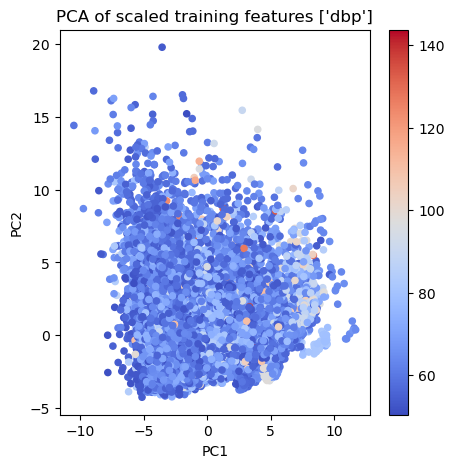

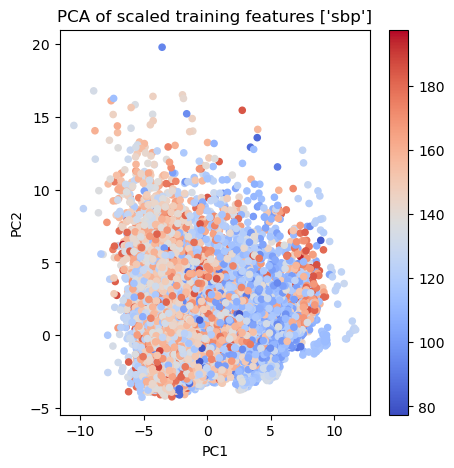

In [14]:
# 2 componemnts PCA plotting
pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(train_scaled_features_df), columns=["PC1", "PC2"])

pca_df.plot.scatter(x="PC1", y="PC2", c=true_train_df['dbp'], figsize=(5,5), title="PCA of scaled training features ['dbp']", colormap="coolwarm")
pca_df.plot.scatter(x="PC1", y="PC2", c=true_train_df['sbp'], figsize=(5,5), title="PCA of scaled training features ['sbp']", colormap="coolwarm")


<AxesSubplot: >

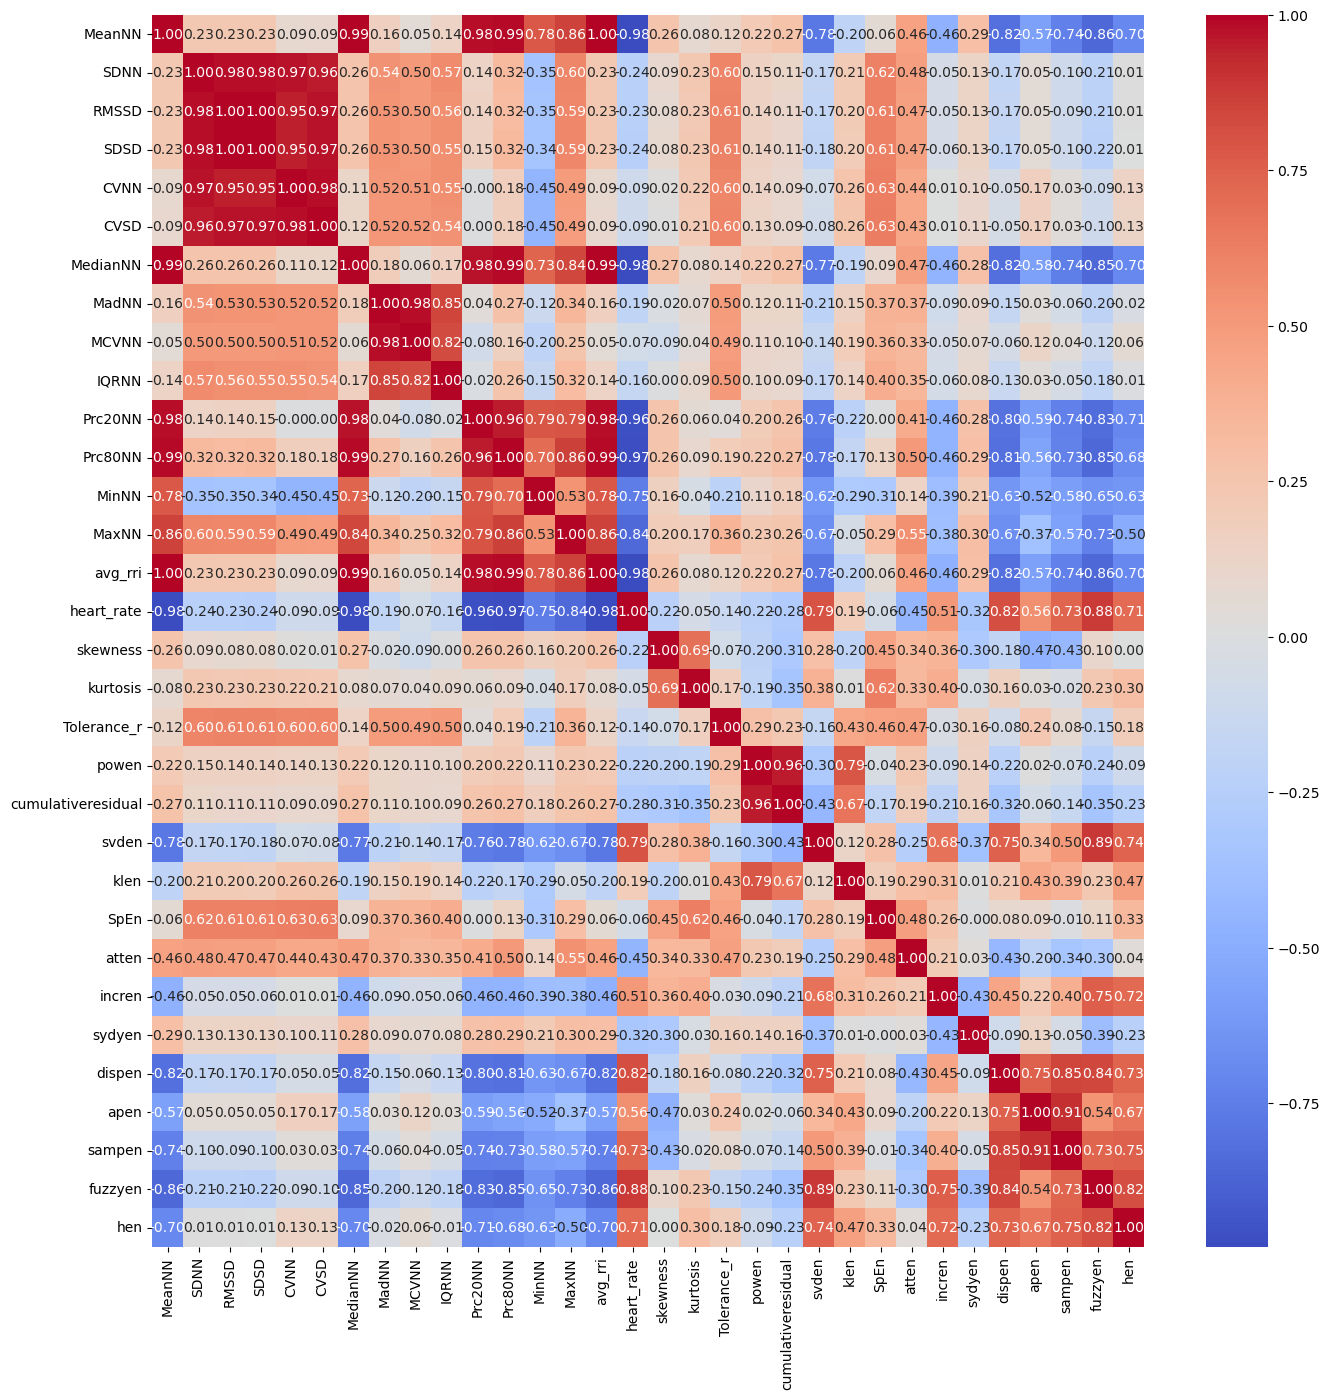

In [57]:
# show heatmap of training features correlation
fig = plt.figure(figsize=(16,16))
sns.heatmap(train_scaled_features_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")

In [16]:
# Define the cross-validation method with 5 folds and 3 repeats
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

In [17]:
# Fine tuning Random Forest Regressor for feature selection

rfr = RandomForestRegressor() # random forest regressor instance

# candidate hyperparameters
rfr_param_grid = {'n_estimators': [100, 200, 300, 400, 500],
                  'max_depth': [None, 5, 10, 15, 20],
                  'max_features': ['auto', 'sqrt', 'log2']}

# create grid search instance
rfr_grid_search = GridSearchCV(rfr, rfr_param_grid, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

# fit grid search on training data['sbp']
rfr_grid_search.fit(train_scaled_features_df, true_train_df['sbp'])
sbp_rfr_best_params = rfr_grid_search.best_params_
print("Best hyperparameters ['sbp']: ", sbp_rfr_best_params)

# fit grid search on training data['dbp']
rfr_grid_search.fit(train_scaled_features_df, true_train_df['dbp'])
dbp_rfr_best_params = rfr_grid_search.best_params_
print("Best hyperparameters ['dbp']: ", dbp_rfr_best_params)


Fitting 15 folds for each of 75 candidates, totalling 1125 fits
Best hyperparameters ['sbp']:  {'max_depth': None, 'max_features': 'auto', 'n_estimators': 400}
Fitting 15 folds for each of 75 candidates, totalling 1125 fits
Best hyperparameters ['dbp']:  {'max_depth': None, 'max_features': 'auto', 'n_estimators': 500}


In [18]:
# Fine tuning Gradient Boosting Regressor for feature selection

gbr = GradientBoostingRegressor() # gradient boosting regressor instance

# candidate hyperparameters
gbr_param_grid = {'loss': ['squared_error', 'absolute_error'],
                  'learning_rate': [0.05, 0.1, 0.5],
                  'n_estimators': [50, 100, 500]}
                  
# create grid search instance
gbr_grid_search = GridSearchCV(gbr, gbr_param_grid, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

# fir grid search on training data['sbp']
gbr_grid_search.fit(train_scaled_features_df, true_train_df['sbp'])
sbp_gbr_best_params = gbr_grid_search.best_params_
print("Best hyperparameters ['sbp']: ", sbp_gbr_best_params)

# fit grid search on training data['dbp']
gbr_grid_search.fit(train_scaled_features_df, true_train_df['dbp'])
dbp_gbr_best_params = gbr_grid_search.best_params_
print("Best hyperparameters ['dbp']: ", dbp_gbr_best_params)

Fitting 15 folds for each of 18 candidates, totalling 270 fits
Best hyperparameters ['sbp']:  {'learning_rate': 0.5, 'loss': 'squared_error', 'n_estimators': 500}
Fitting 15 folds for each of 18 candidates, totalling 270 fits
Best hyperparameters ['dbp']:  {'learning_rate': 0.5, 'loss': 'absolute_error', 'n_estimators': 500}


In [44]:
# Fit and get feature importance from fine tuning Random Forest Regressor and Gradient Boosting Regressor
features_importance_list = []

rfr = RandomForestRegressor(**sbp_rfr_best_params)
rfr.fit(train_scaled_features_df, true_train_df['sbp'])
features_importance_list.append(rfr.feature_importances_)

rfr = RandomForestRegressor(**dbp_rfr_best_params)
rfr.fit(train_scaled_features_df, true_train_df['dbp'])
features_importance_list.append(rfr.feature_importances_)

gbr = GradientBoostingRegressor(**sbp_gbr_best_params)
gbr.fit(train_scaled_features_df, true_train_df['sbp'])
features_importance_list.append(gbr.feature_importances_)

gbr = GradientBoostingRegressor(**dbp_gbr_best_params)
gbr.fit(train_scaled_features_df, true_train_df['dbp'])
features_importance_list.append(gbr.feature_importances_)


<AxesSubplot: title={'center': 'Mean of features importance from fine tuning Random Forest Regressor and Gradient Boosting Regressor'}, xlabel='Name'>

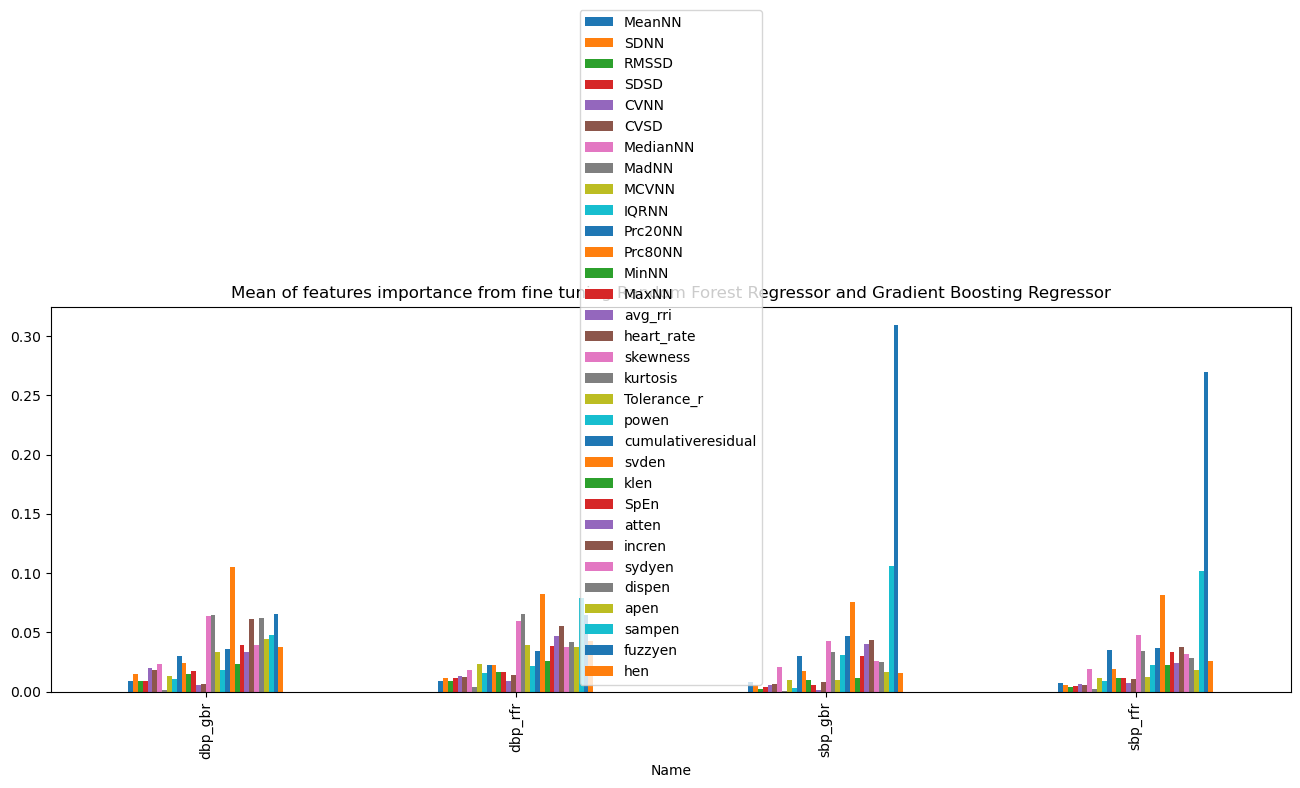

In [51]:
# plot mean of features importance from fine tuning Random Forest Regressor and Gradient Boosting Regressor
features_importance_df = pd.DataFrame(features_importance_list, columns=train_features_df.columns)
features_importance_df['Name'] = ['sbp_rfr', 'dbp_rfr', 'sbp_gbr', 'dbp_gbr']

features_importance_df.groupby('Name').mean().plot.bar(figsize=(16,5), title="Mean of features importance from fine tuning Random Forest Regressor and Gradient Boosting Regressor")

In [56]:
# select top 10 most important features based on observation of correlation heatmap, RandomForestRegressor.features_importance_ and GradientBoostingRegressor.feature_importances_
top_features = ['sampen', 'fuzzyen', 'svden', 'skewness', 'MadNN', 'incren', 'dispen', 'kurtosis', 'SpEn', 'cumulativeresidual']
len(top_features)

10

## (5) Models selection

Support Vector Regression (SVR) and Multi-Layer Perceptron (MLP) are both machine learning models that can be used tackle on complex, nonlinear relationships between the input and output variable. 

SVR and MLP are two models selected to train top 10 important features, and predict the value of systolic blood pressure, diastolic blood pressure. MLP particuly can help the further works in deep neural network if needed.

Support Vector Regression (SVR) is a type of supervised learning algorithm that uses support vector machines (SVMs) to perform regression tasks. The goal of SVR is to find a function that maps the input variables to the output variable, while minimizing the prediction error. The model works by finding a hyperplane that maximizes the margin between the predicted values and the actual values, subject to a regularization parameter. The hyperplane is determined by a subset of the training data, called the support vectors.

Here are some of the most important hyperparameters in SVR:
- Penalty parameter (C): The penalty parameter controls the trade-off between achieving a low training error and a low testing error. A higher value of C will result in a more complex model that is better able to fit the training data, but may also lead to overfitting.
- Kernel coefficient (gamma): The kernel coefficient determines the shape of the decision boundary. A higher value of gamma will result in a more complex boundary that is better able to fit the training data, but may also lead to overfitting
- Degree of polynomial kernel (degree): The degree of the polynomial kernel is only used when the kernel type is set to polynomial. It determines the degree of the polynomial used to transform the input data.


Multi-Layer Perceptron (MLP) is a type of artificial neural network that is used for both classification and regression tasks. MLPs are composed of multiple layers of interconnected nodes, or neurons, that use nonlinear activation functions to transform the input into the output. The model is trained using backpropagation, which is an iterative optimization algorithm that adjusts the weights of the neurons to minimize the prediction error.

here are some the most important hyperparameters in MLP:
- Number of hidden layers: MLPs have one or more hidden layers of neurons that process the input and transform it into the output. The number of hidden layers can vary depending on the complexity of the problem and the amount of data available. Increasing the number of hidden layers can allow the model to learn more complex relationships between the input and output, but can also increase the risk of overfitting.
- Activation function: Activation functions are used to introduce nonlinearity into the model, which is necessary to learn complex relationships in the data. Common activation functions include sigmoid, tanh, and ReLU. The choice of activation function can affect the model's accuracy and training speed.
- Optimizer : the choice of optimizer depends on the specific requirements of the task at hand, such as the size of the dataset, the complexity of the model, and the need for accuracy and speed. Some common optimizers used in neural networks include stochastic gradient descent (SGD), Adagrad, Adam, and RMSprop. These optimizers differ in the way they update the weights of the model and the speed and stability of the training process.
- Validation fraction : the precentage of validation data in given training data.A small validation fraction can lead to overfitting, as the model may not be able to generalize well to new data. A large validation fraction can lead to underfitting, as the model may not be able to learn the complex patterns in the data.


Two models was first fine tuning by graid search method with 5 fold 3 repeats cross validation for 'sbp' 'dbp'  target result in four best parameters can be used in next model training part.

In [80]:
# Fine tuning SVM Regression  

# candidate hyperparameters
svr_param_grid = {'C': [0.1, 1, 10, 100],
                  'gamma': [0.1, 0.01, 0.001],
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

svr = SVR() # support vector regression instance

# create grid search instance
svr_grid_search = GridSearchCV(svr, svr_param_grid, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

# fine tuning for ['sdp'] target
svr_grid_search.fit(train_scaled_features_df[top_features], true_train_df['sbp'])
sdp_svr_best_params = svr_grid_search.best_params_
print("Best hyperparameters ['sbp']: ", sdp_svr_best_params)


# fine tuning for ['dbp'] target
svr_grid_search.fit(train_scaled_features_df[top_features], true_train_df['dbp'])
dbp_svr_best_params = svr_grid_search.best_params_
print("Best hyperparameters ['dbp']: ", dbp_svr_best_params)

Fitting 15 folds for each of 48 candidates, totalling 720 fits
Best hyperparameters ['sbp']:  {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Fitting 15 folds for each of 48 candidates, totalling 720 fits
Best hyperparameters ['dbp']:  {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


In [81]:
# Fine tuning MLP Regression

# candidate hyperparameters
mlp_param_grid = {'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)],
                  'activation': ['relu', 'logistic'],
                  'solver' : ['adam', 'sgd'],
                  'validation_fraction': [0.2, 0.5]}

mlp = MLPRegressor(early_stopping=True) # multi-layer perceptron regressor instance  
                  
# create grid search instance
mlp_grid_search = GridSearchCV(mlp, mlp_param_grid, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)


# fine tuning for ['sdp'] target
mlp_grid_search.fit(train_scaled_features_df[top_features], true_train_df['sbp'])
sdp_mlp_best_params = mlp_grid_search.best_params_
print("Best hyperparameters ['sbp']: ", sdp_mlp_best_params)


# fine tuning for ['dbp'] target
mlp_grid_search.fit(train_scaled_features_df[top_features], true_train_df['dbp'])
dbp_mlp_best_params = mlp_grid_search.best_params_
print("Best hyperparameters ['dbp']: ", dbp_mlp_best_params)


Fitting 15 folds for each of 24 candidates, totalling 360 fits
Best hyperparameters ['sbp']:  {'activation': 'logistic', 'hidden_layer_sizes': (100, 100), 'solver': 'sgd', 'validation_fraction': 0.2}
Fitting 15 folds for each of 24 candidates, totalling 360 fits
Best hyperparameters ['dbp']:  {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'solver': 'adam', 'validation_fraction': 0.2}


## (6) Models training

In this part, Two Support Vector Machine Regressors and two MLP regressor were simply trained with their best_params and selected features. 


In [82]:
# SVM Regression

# train on SVR for ['sbp'] target
svr = SVR(**sdp_svr_best_params)
svr.fit(train_scaled_features_df[top_features], true_train_df['sbp'])
svr_sbp_pred = svr.predict(test_scaled_features_df[top_features])

# train on SVR for ['dbp'] target
svr = svr = SVR(**dbp_svr_best_params)
svr.fit(train_scaled_features_df[top_features], true_train_df['dbp'])
svr_dbp_pred = svr.predict(test_scaled_features_df[top_features])


In [83]:
# MLP Regression

# train on MLP for ['sbp'] target
mlp = MLPRegressor(**sdp_mlp_best_params, early_stopping=True)
mlp.fit(train_scaled_features_df[top_features], true_train_df['sbp'])
mlp_sbp_pred = mlp.predict(test_scaled_features_df[top_features])


# train on MLP for ['dbp'] target
mlp = MLPRegressor(**dbp_mlp_best_params, early_stopping=True)
mlp.fit(train_scaled_features_df[top_features], true_train_df['dbp'])
mlp_dbp_pred = mlp.predict(test_scaled_features_df[top_features])


## (8) Models evaluation

In this part, the prediction of four models were evulated by concordance index (c-index) and mean absolute error(mae). 

MAE is a measure of the average difference between the predicted and actual values of a continuous variable. It is calculated by taking the absolute difference between each predicted value and its corresponding actual value, and then averaging over all the samples in the test set. The lower the MAE, the better the performance of the model.

C-index, on the other hand, is a measure of the predictive power of a model for survival analysis tasks. It is calculated as the proportion of all pairs of samples in the test set that are correctly ordered with respect to their predicted survival time. The C-index takes values between 0.5 and 1, where a value of 0.5 indicates a model that is no better than random, and a value of 1 indicates a perfect model. In general, a higher C-index indicates better performance of the model.

In [90]:
# Obtain the mean absolute error and concordance index (c-index)

mae_svr_sbp = mean_absolute_error(true_test_df['sbp'], svr_sbp_pred)
mae_svr_dbp = mean_absolute_error(true_test_df['dbp'], svr_dbp_pred)
mae_mlp_sbp = mean_absolute_error(true_test_df['sbp'], mlp_sbp_pred)
mae_mlp_dbp = mean_absolute_error(true_test_df['dbp'], mlp_dbp_pred)

cindex_svr_sbp = concordance_index(true_test_df['sbp'], svr_sbp_pred)
cindex_svr_dbp = concordance_index(true_test_df['dbp'], svr_dbp_pred)
cindex_mlp_sbp = concordance_index(true_test_df['sbp'], mlp_sbp_pred)
cindex_mlp_dbp = concordance_index(true_test_df['dbp'], mlp_dbp_pred)


result = [{'Model' : 'SVR', 'Target' : 'sbp', 'MAE' : mae_svr_sbp, 'C-index' : cindex_svr_sbp},
          {'Model' : 'SVR', 'Target' : 'dbp', 'MAE' : mae_svr_dbp, 'C-index' : cindex_svr_dbp},
          {'Model' : 'MLP', 'Target' : 'sbp', 'MAE' : mae_mlp_sbp, 'C-index' : cindex_mlp_sbp},
          {'Model' : 'MLP', 'Target' : 'dbp', 'MAE' : mae_mlp_dbp, 'C-index' : cindex_mlp_dbp}]

result_df = pd.DataFrame(result)

result_df


,Model,Target,MAE,C-index
0,SVR,sbp,10.716830,0.783091
1,SVR,dbp,4.993050,0.748422
2,MLP,sbp,10.660200,0.790894
3,MLP,dbp,5.231168,0.738001


By compare the our Support Vector Regressor (SVR) and Multi-Layer Perceptron (MLP), we can observe:
- For the 'sbp' target variable, both SVR and MLP achieve similar C-index values, but MLP has a slightly lower MAE than SVR.
- For the 'dbp' target variable, SVR has a slightly higher C-index than MLP, but MLP has a lower MAE than SVR.
- Predicting distolic blood preesure 'dbp' might more challenge than systolic blood pressure since both models result in poorer performance
- Overall, both models perform reasonably well on both target variables, with C-index values above 0.7 and MAE values around 5-10.

## (9) Conlusion

From the comparsion of SVR and MLP, we find both model can well leared the hidden pattern in our extracted top 10 informative features from entropy domain and time domain, and result in quite similar MAE and c-index. 

After reaching the result, we are impressived by such good result, and start wandering whether the performance is over-opstimistic. and might there are dataleake somewhere between test and train data? Our project has already involed techniques, such as grid search, cross validation, features selection, regularzation in algorithms to address this problem. Indeed, featues 'sampen', 'fuzzyen', 'svden', 'dispen' are realativly dependent on each other. while features 'skewness', 'MadNN', 'incren', 'kurtosis', 'SpEn', 'cumulativeresidual' are more independent from others. In the end, we have no idea whether the models is over-opstimic or not. 